In [1]:
from google.colab import files

# Select your model file (e.g., best_model.keras) from local system
uploaded = files.upload()


Saving best_model_optimized_2.keras to best_model_optimized_2.keras


In [5]:
# !/usr/bin/env python
# Colab notebook cell

import os
from pathlib import Path
import urllib.request
import zipfile

# URL for the by_merge zip (2nd edition) from NIST SD19
# You might need to use the exact URL; this is the one listed on the catalog.
BY_MERGE_URL = "https://s3.amazonaws.com/nist-srd/SD19/by_merge.zip"

# Target paths
data_root = "/content"
zip_path = os.path.join(data_root, "by_merge.zip")
extract_path = os.path.join(data_root, "by_merge")

# Download the zip file
if not os.path.exists(zip_path):
    print("📥 Downloading the by_merge dataset...")
    urllib.request.urlretrieve(BY_MERGE_URL, zip_path)
    print("✅ Download complete.")
else:
    print("ℹ️ by_merge.zip already exists, skipping download.")

# Unzip
if not os.path.exists(extract_path):
    print("📂 Extracting zip file...")
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(data_root)
    print("✅ Extraction done.")
else:
    print("ℹ️ by_merge folder already exists, skipping extraction.")

# Optional: scan dataset to confirm classes & print class folders
valid_exts = {".png", ".jpg", ".tif", ".tiff", ".bmp"}

classes = set()
file_count = 0

for root, dirs, files in os.walk(extract_path):
    for fname in files:
        ext = Path(fname).suffix.lower()
        if ext in valid_exts:
            file_count += 1
            # class name = top-level folder under by_merge
            rel = Path(root).relative_to(extract_path)
            parts = rel.parts
            if len(parts) > 0:
                class_name = parts[0]
                classes.add(class_name)

print(f"\n📊 Total valid image files found: {file_count}")
print(f"🔤 Classes found ({len(classes)}): {sorted(classes)}")


📥 Downloading the by_merge dataset...
✅ Download complete.
📂 Extracting zip file...
✅ Extraction done.

📊 Total valid image files found: 814255
🔤 Classes found (47): ['30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '41', '42', '43_63', '44', '45', '46', '47', '48', '49_69', '4a_6a', '4b_6b', '4c_6c', '4d_6d', '4e', '4f_6f', '50_70', '51', '52', '53_73', '54', '55_75', '56_76', '57_77', '58_78', '59_79', '5a_7a', '61', '62', '64', '65', '66', '67', '68', '6e', '71', '72', '74']


In [6]:
# -*- coding: utf-8 -*-
"""Pen_to_Pixel Testing & Dataset Scanning in Colab"""

# Install required packages
!pip install tensorflow matplotlib scikit-learn seaborn Pillow

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from google.colab import files
from pathlib import Path

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# -----------------------------
# Model loading
# -----------------------------
MODEL_PATH = "/content/best_model_optimized_2.keras"  # 🔹 Put your uploaded model filename here

def load_model(model_path):
    """Load the trained model"""
    try:
        model = keras.models.load_model(model_path)
        print(f"✅ Model loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

# -----------------------------
# Dataset scanning (by_merge)
# -----------------------------
VALID_EXTENSIONS = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}

def scan_dataset(dataset_dir):
    """Scan dataset and return classes and counts"""
    dataset_dir = Path(dataset_dir)
    filepaths, labels = [], []

    for root, _, files in os.walk(dataset_dir):
        for f in files:
            if Path(f).suffix.lower() not in VALID_EXTENSIONS:
                continue
            filepath = os.path.join(root, f)
            class_name = Path(root).relative_to(dataset_dir).parts[0]
            filepaths.append(filepath)
            labels.append(class_name)

    classes = sorted(set(labels))
    print(f"\n📊 Found {len(filepaths)} images across {len(classes)} classes")
    print(f"🔤 Classes ({len(classes)}): {classes}")
    return filepaths, labels, classes

# -----------------------------
# Image preprocessing
# -----------------------------
def load_and_preprocess_image(image_path, img_size=(128, 128)):
    """Load and preprocess a single image"""
    try:
        img = Image.open(image_path).convert('L')
        img = img.resize(img_size)
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=-1)
        img_array = np.expand_dims(img_array, axis=0)
        return img_array
    except Exception as e:
        print(f"❌ Error loading image {image_path}: {e}")
        return None

def predict_on_image(model, image_path, class_names):
    """Make prediction on a single image"""
    processed_image = load_and_preprocess_image(image_path)
    if processed_image is None:
        return None, None
    predictions = model.predict(processed_image, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    return predicted_class, confidence

# -----------------------------
# File download helper
# -----------------------------
def download_file(filepath):
    """Download file from Colab to local machine"""
    if os.path.exists(filepath):
        files.download(filepath)
        print(f"📥 Download started for {filepath}")
    else:
        print(f"❌ File {filepath} not found")

# -----------------------------
# Main
# -----------------------------
def main():
    # Load model
    model = load_model(MODEL_PATH)
    if model is None:
        return

    # Print model summary
    print("\n" + "="*60)
    model.summary()
    print("="*60)

    # Scan dataset (by_merge)
    dataset_path = "/content/by_merge"  # 🔹 Change to your dataset folder
    if os.path.exists(dataset_path):
        filepaths, labels, classes = scan_dataset(dataset_path)
    else:
        print(f"❌ Dataset not found at {dataset_path}")

    # Example: predict on a random image
    if filepaths:
        sample_image = filepaths[0]
        pred_class, conf = predict_on_image(model, sample_image, classes)
        print(f"\n🔍 Sample Prediction: {sample_image}")
        print(f"   ➡ Predicted Class: {classes[pred_class]} (Conf: {conf:.3f})")

    # Example: Download trained model again
    download_file(MODEL_PATH)

if __name__ == "__main__":
    main()


✅ Model loaded successfully from /content/best_model_optimized_2.keras



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,208,847 (31.31 MB)

 Trainable params: 2,734,831 (10.43 MB)

 Non-trainable params: 4,352 (17.00 KB)

 Optimizer params: 5,469,664 (20.87 MB)


📊 Found 814255 images across 47 classes
🔤 Classes (47): ['30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '41', '42', '43_63', '44', '45', '46', '47', '48', '49_69', '4a_6a', '4b_6b', '4c_6c', '4d_6d', '4e', '4f_6f', '50_70', '51', '52', '53_73', '54', '55_75', '56_76', '57_77', '58_78', '59_79', '5a_7a', '61', '62', '64', '65', '66', '67', '68', '6e', '71', '72', '74']

🔍 Sample Prediction: /content/by_merge/37/hsf_0/hsf_0_03267.png
   ➡ Predicted Class: 42 (Conf: 1.000)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Download started for /content/best_model_optimized_2.keras


✅ Model loaded successfully from /content/best_model_optimized_2.keras
📂 Found 47 classes in dataset
🔤 Classes: ['30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '41', '42', '43_63', '44', '45', '46', '47', '48', '49_69', '4a_6a', '4b_6b', '4c_6c', '4d_6d', '4e', '4f_6f', '50_70', '51', '52', '53_73', '54', '55_75', '56_76', '57_77', '58_78', '59_79', '5a_7a', '61', '62', '64', '65', '66', '67', '68', '6e', '71', '72', '74']



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,208,847 (31.31 MB)

 Trainable params: 2,734,831 (10.43 MB)

 Non-trainable params: 4,352 (17.00 KB)

 Optimizer params: 5,469,664 (20.87 MB)


🔍 Testing on dataset: /content/by_merge/
📸 Found 814255 images in the directory


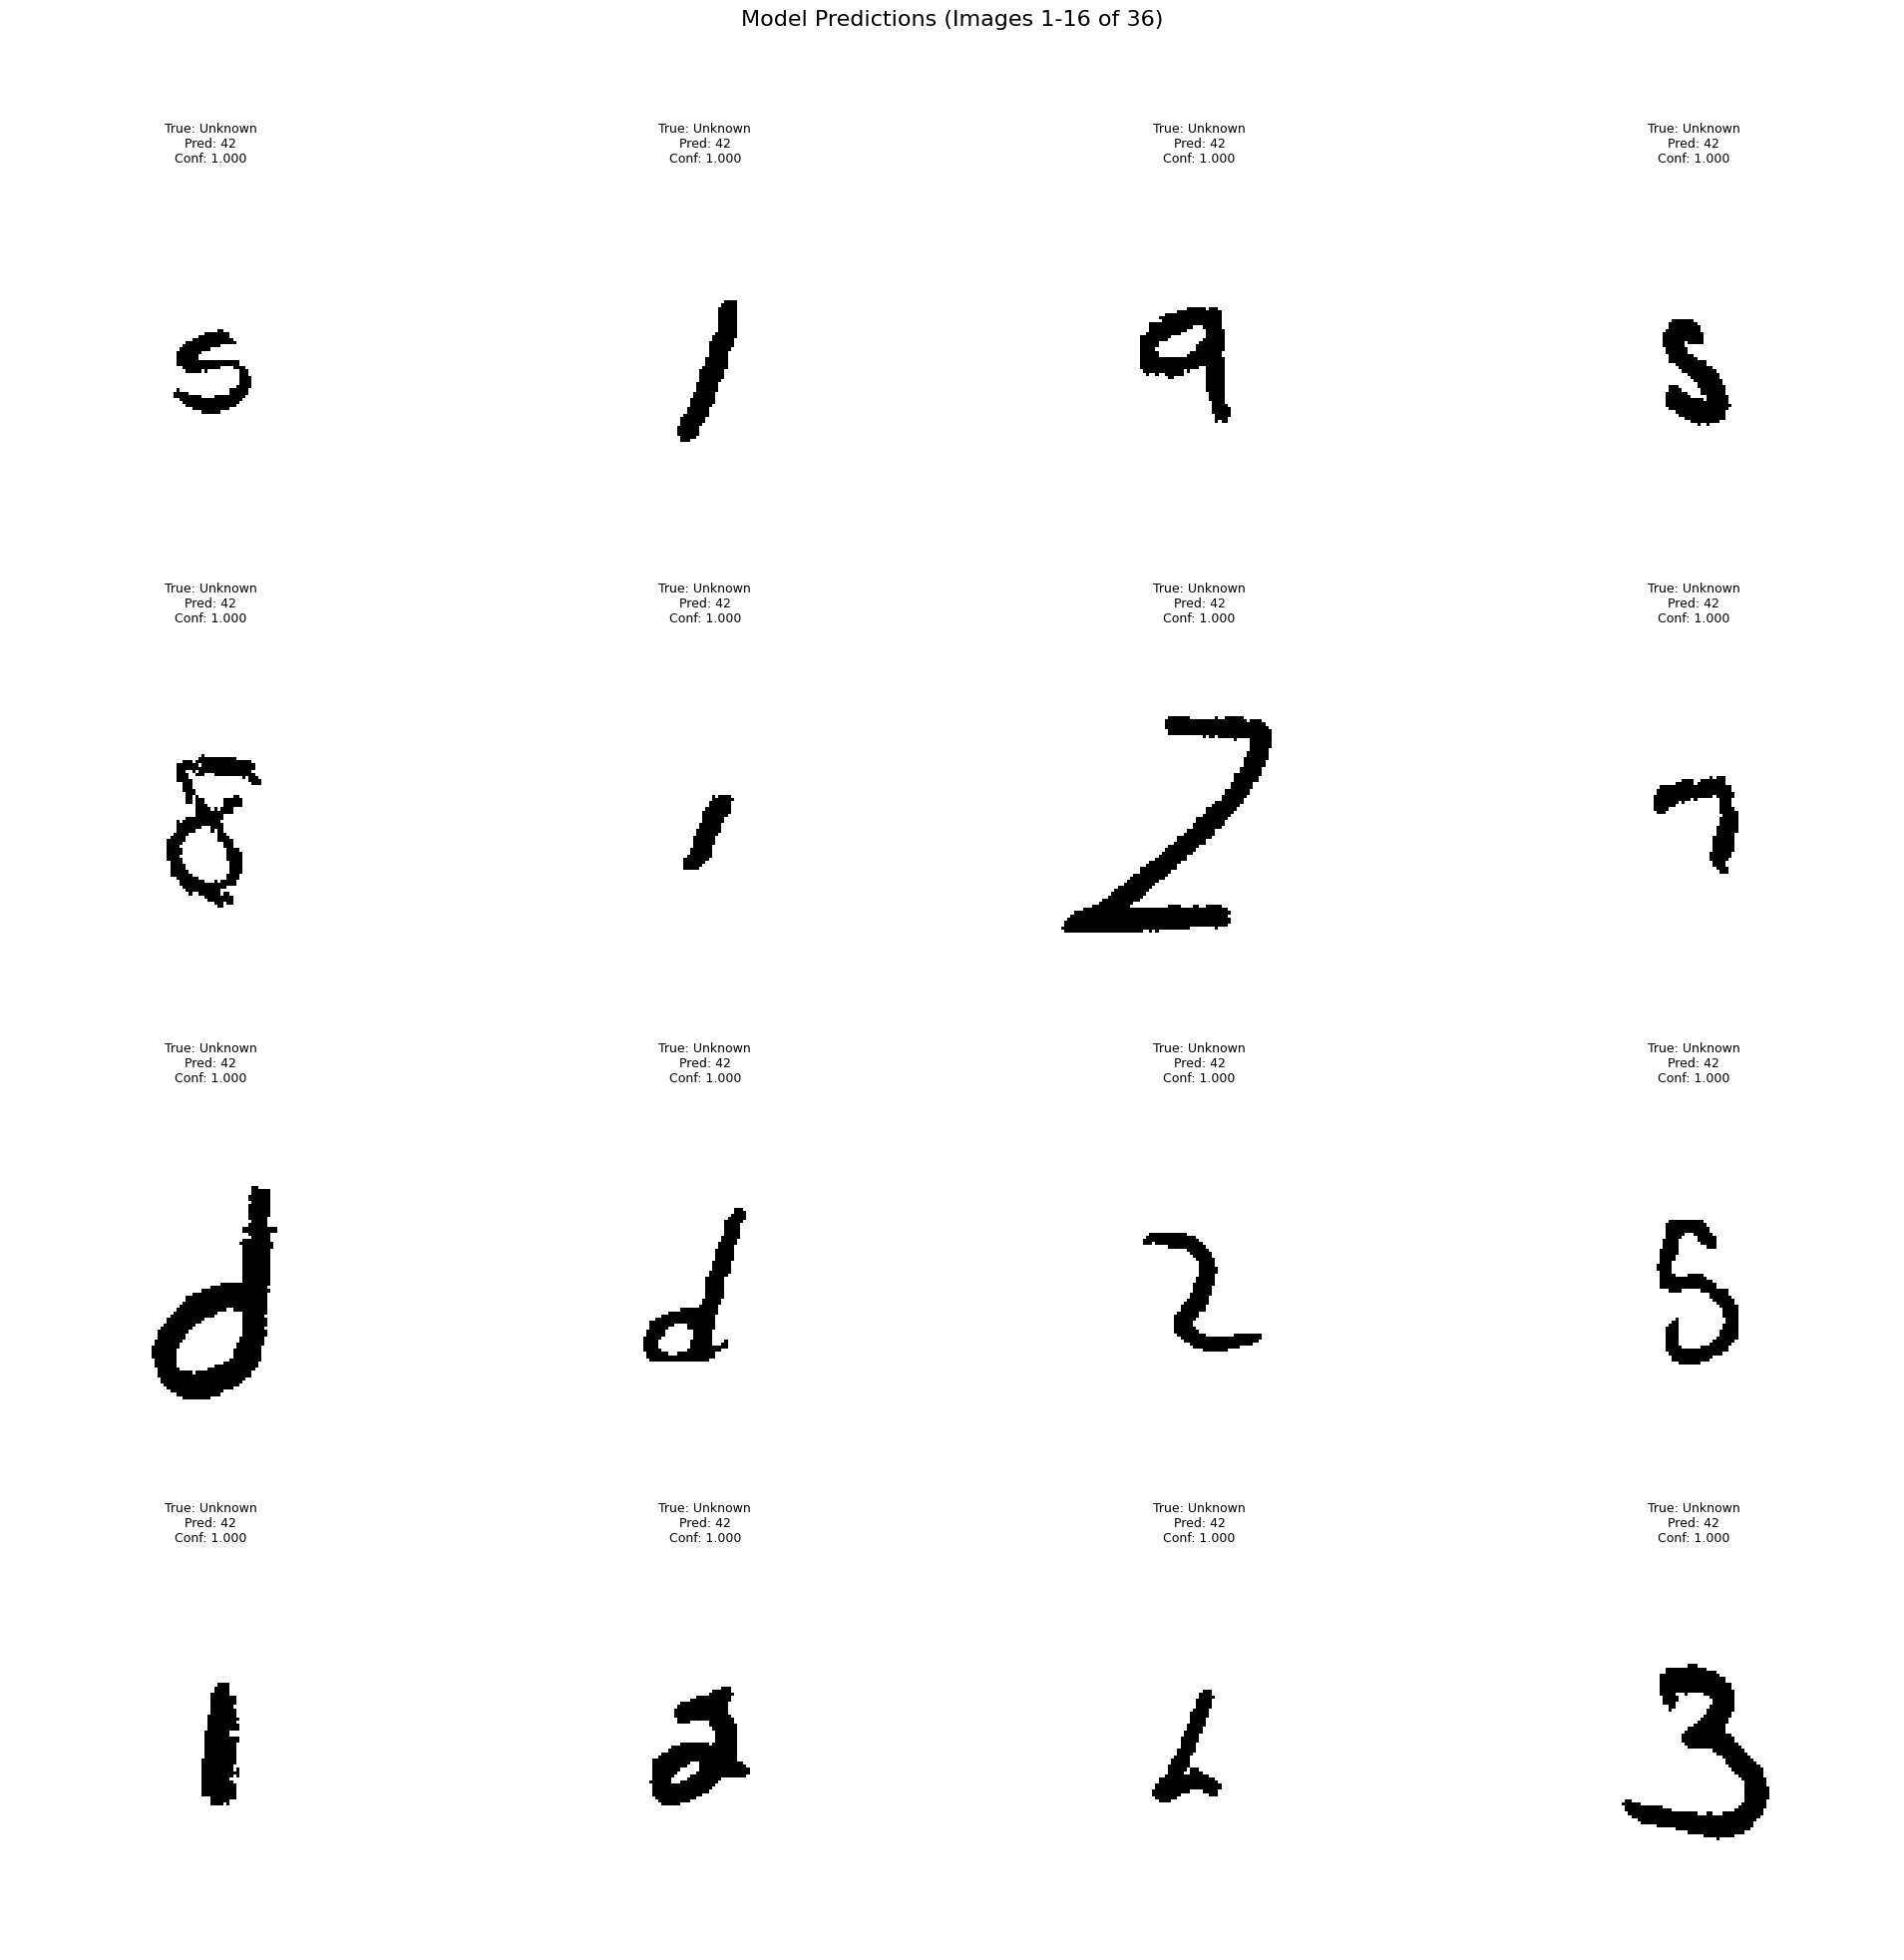

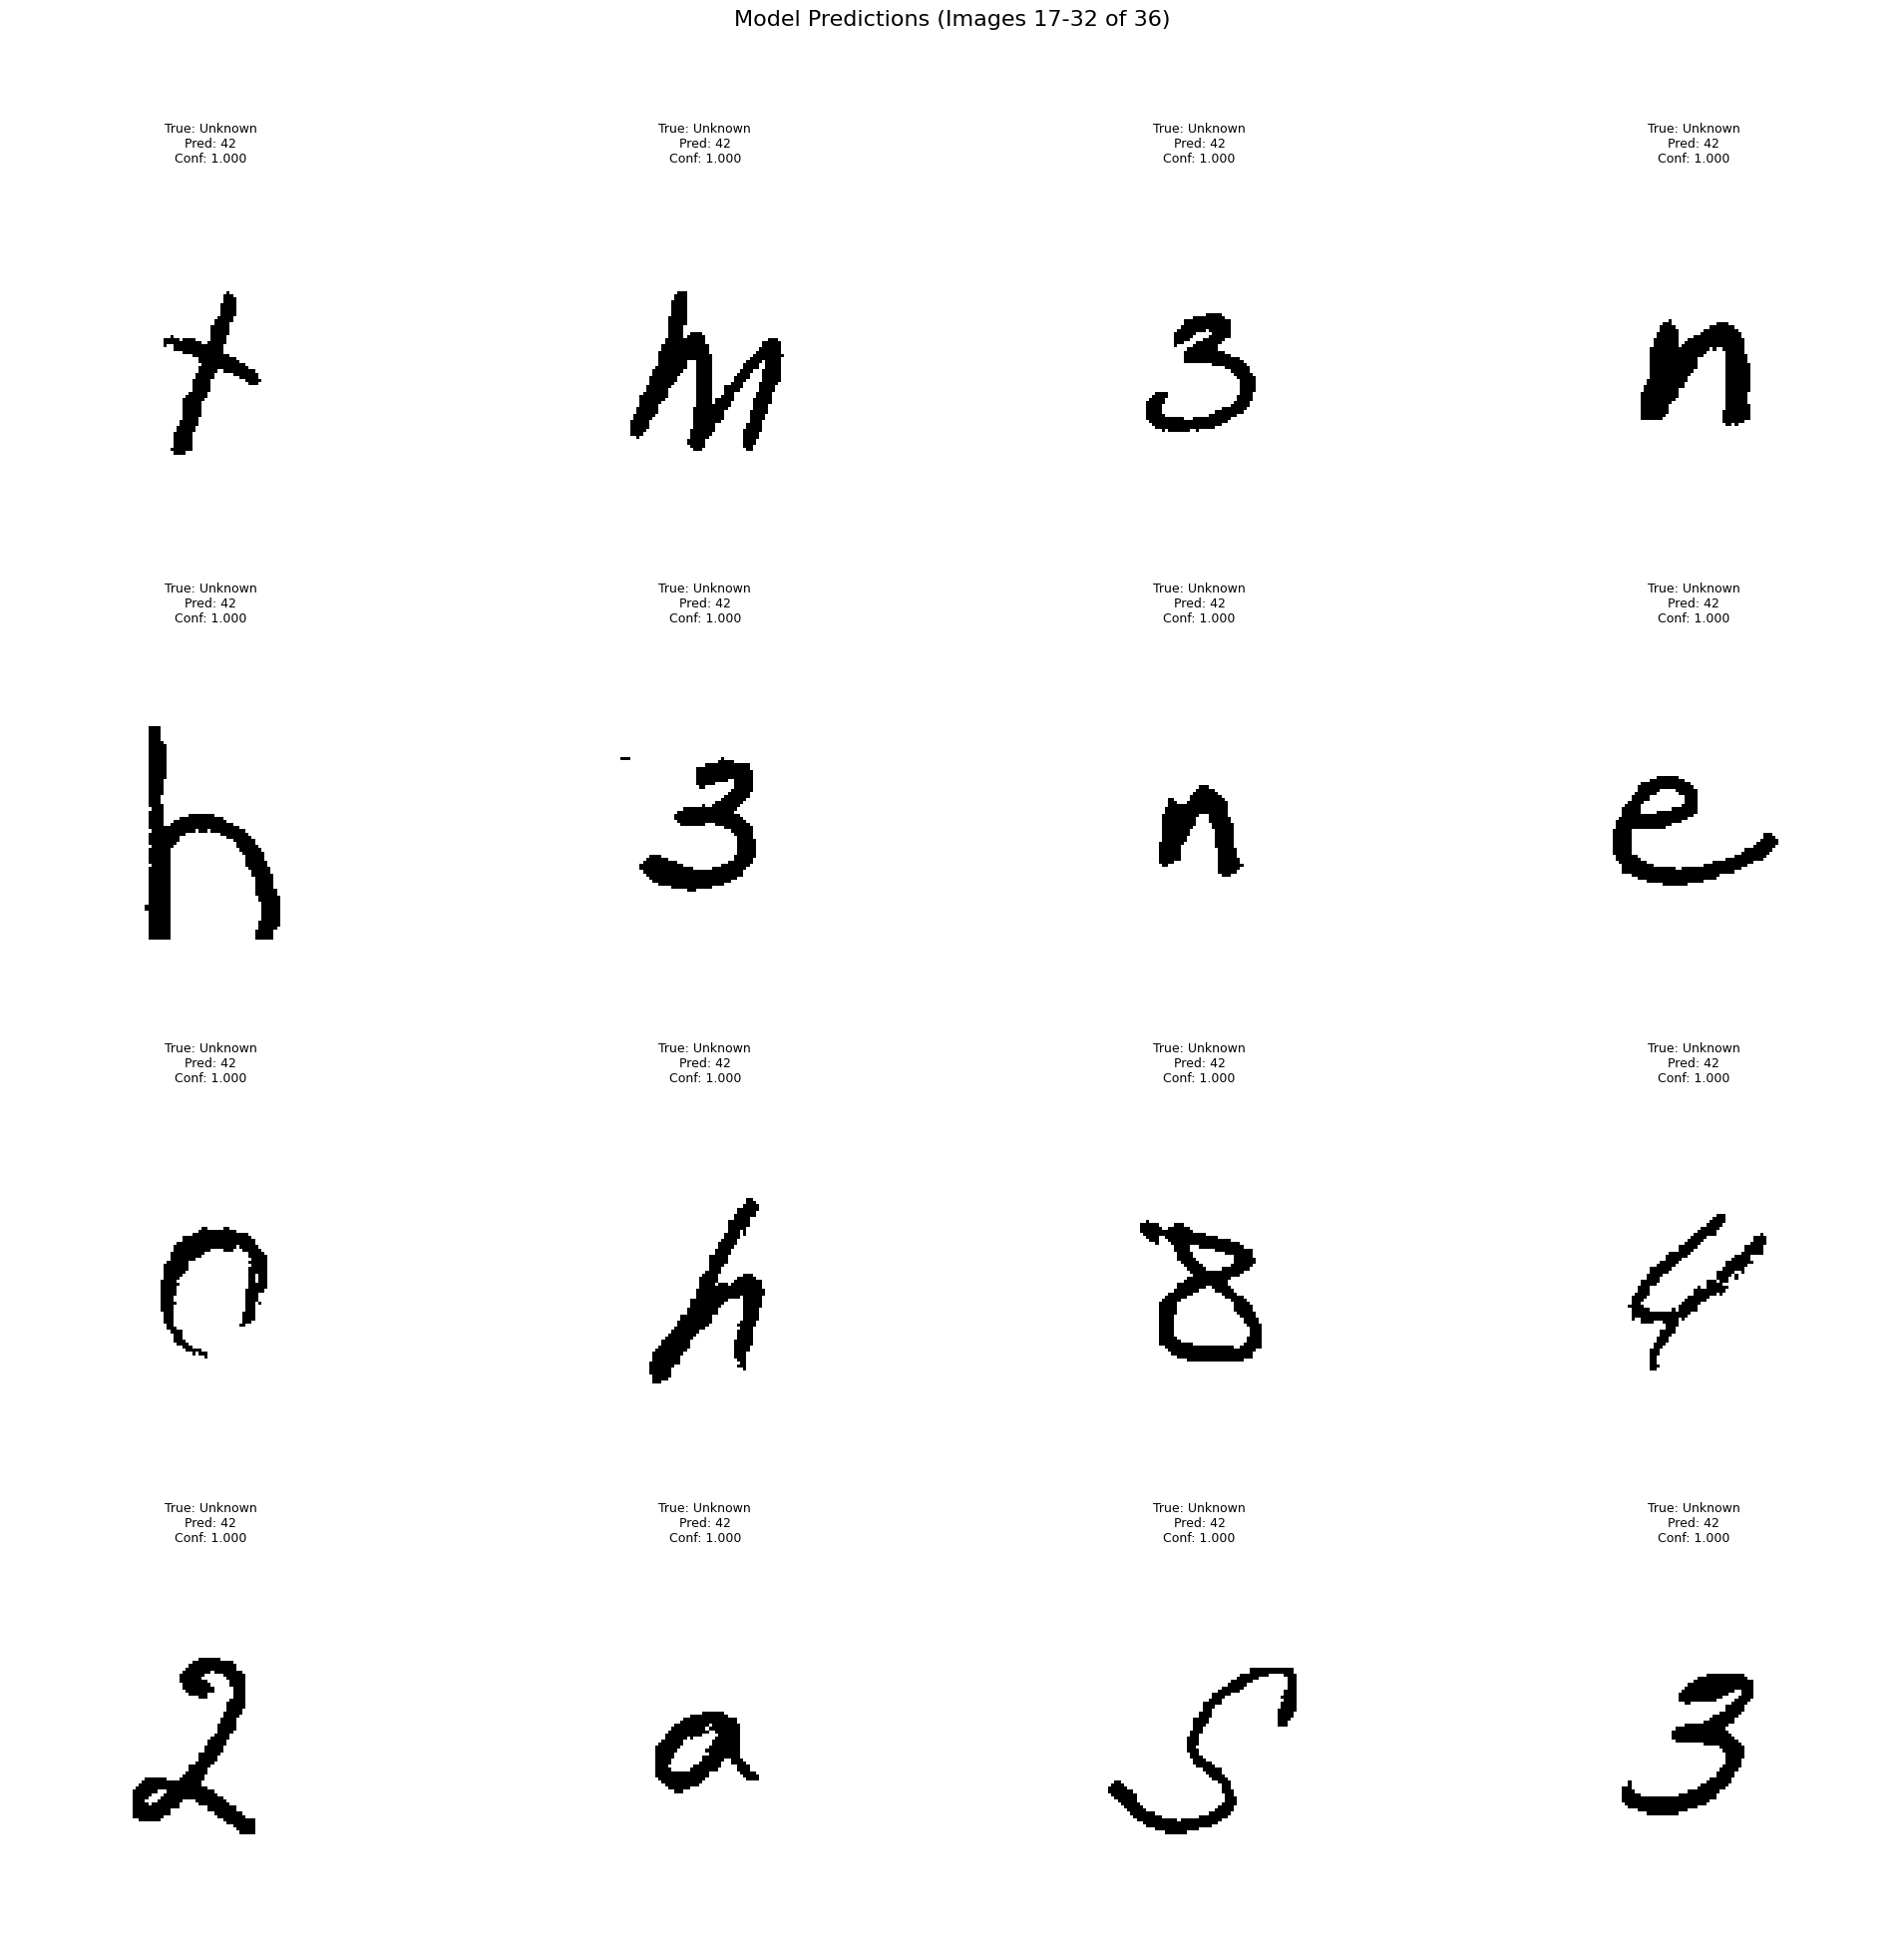

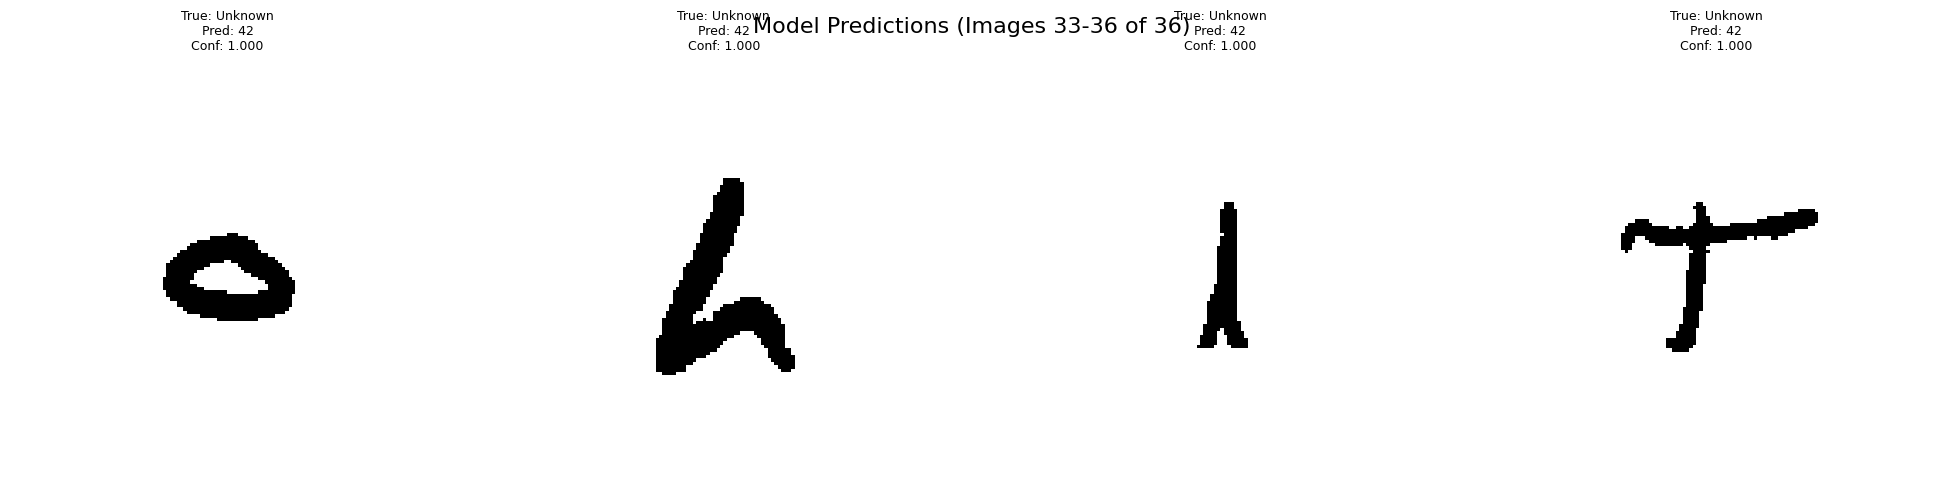

In [18]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def load_model(model_path):
    """Load the trained model"""
    try:
        model = keras.models.load_model(model_path)
        print(f"✅ Model loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

def scan_dataset_classes(dataset_dir):
    """Scan dataset directory and return sorted class list"""
    if not os.path.exists(dataset_dir):
        print(f"❌ Dataset path {dataset_dir} not found")
        return []

    classes = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])
    print(f"📂 Found {len(classes)} classes in dataset")
    print("🔤 Classes:", classes)
    return classes

def load_and_preprocess_image(image_path, img_size=(128, 128)):
    """Load and preprocess a single image"""
    try:
        img = Image.open(image_path).convert('L')   # grayscale
        img = img.resize(img_size)
        img_array = np.array(img) / 255.0          # normalize
        img_array = np.expand_dims(img_array, axis=-1)  # add channel
        img_array = np.expand_dims(img_array, axis=0)   # add batch
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def predict_on_image(model, image_path, class_names):
    """Make prediction on a single image"""
    processed_image = load_and_preprocess_image(image_path)
    if processed_image is None:
        return None, None

    predictions = model.predict(processed_image, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    return predicted_class, confidence

def test_on_directory(model, test_dir, class_names, num_samples=36):
    """Test the model on a directory of images"""
    image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']
    image_paths = []

    for root, _, files in os.walk(test_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_paths.append(os.path.join(root, file))

    if not image_paths:
        print(f"No images found in {test_dir}")
        return

    print(f"📸 Found {len(image_paths)} images in the directory")

    if len(image_paths) > num_samples:
        selected_paths = np.random.choice(image_paths, num_samples, replace=False)
    else:
        selected_paths = image_paths
        num_samples = len(image_paths)

    images_per_figure = 16
    num_figures = (num_samples + images_per_figure - 1) // images_per_figure

    for fig_idx in range(num_figures):
        start_idx = fig_idx * images_per_figure
        end_idx = min((fig_idx + 1) * images_per_figure, num_samples)
        current_paths = selected_paths[start_idx:end_idx]

        num_cols = 4
        num_rows = (len(current_paths) + num_cols - 1) // num_cols

        plt.figure(figsize=(20, 5 * num_rows))
        plt.suptitle(f'Model Predictions (Images {start_idx + 1}-{end_idx} of {num_samples})',
                     fontsize=16, y=0.98)

        for i, image_path in enumerate(current_paths):
            predicted_class, confidence = predict_on_image(model, image_path, class_names)
            if predicted_class is None:
                continue

            predicted_label = class_names[predicted_class] if predicted_class < len(class_names) else f"Unknown({predicted_class})"

            folder_name = os.path.basename(os.path.dirname(image_path))
            actual_label = "Unknown"
            title_color = 'black'

            if folder_name in class_names:
                actual_label = folder_name
                title_color = 'green' if predicted_label == actual_label else 'red'

            img = Image.open(image_path).convert('L').resize((128, 128))
            img_array = np.array(img)

            plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(img_array, cmap='gray')

            plt.title(f'True: {actual_label}\nPred: {predicted_label}\nConf: {confidence:.3f}',
                      color=title_color, fontsize=9, pad=5)
            plt.axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

def main():
    # ⚡ Update these paths for Colab
    model_path = "/content/best_model_optimized_2.keras"   # uploaded model file
    test_dir = "/content/by_merge/"  # uploaded dataset directory

    # Load the model
    model = load_model(model_path)
    if model is None:
        return

    # Scan dataset and get class names
    class_names = scan_dataset_classes(test_dir)
    if not class_names:
        return

    # Show model summary
    print("\n" + "="*60)
    model.summary()
    print("="*60)

    # Run tests
    print(f"\n🔍 Testing on dataset: {test_dir}")
    test_on_directory(model, test_dir, class_names, num_samples=36)

if __name__ == "__main__":
    main()


Found 814255 files belonging to 47 classes.
✅ Found 47 classes
🔤 Classes: ['30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '41', '42', '43_63', '44', '45', '46', '47', '48', '49_69', '4a_6a', '4b_6b', '4c_6c', '4d_6d', '4e', '4f_6f', '50_70', '51', '52', '53_73', '54', '55_75', '56_76', '57_77', '58_78', '59_79', '5a_7a', '61', '62', '64', '65', '66', '67', '68', '6e', '71', '72', '74']


KeyboardInterrupt: 

🎯 SD19 by_merge Dataset Testing Analysis
📋 Classes: 47
   0-9: Digits
   10-35: Uppercase A-Z
   36-46: Lowercase a-k
✅ Model loaded successfully from /content/best_model_optimized_2.keras
📊 Model input shape: (None, 128, 128, 1)
📊 Model output shape: (None, 47)
🔍 Analyzing SD19 by_merge dataset in: /content/by_merge
📁 Found 814255 images


Processing images: 100%|██████████| 48/48 [00:04<00:00, 11.35it/s]



📈 Generating visualizations...


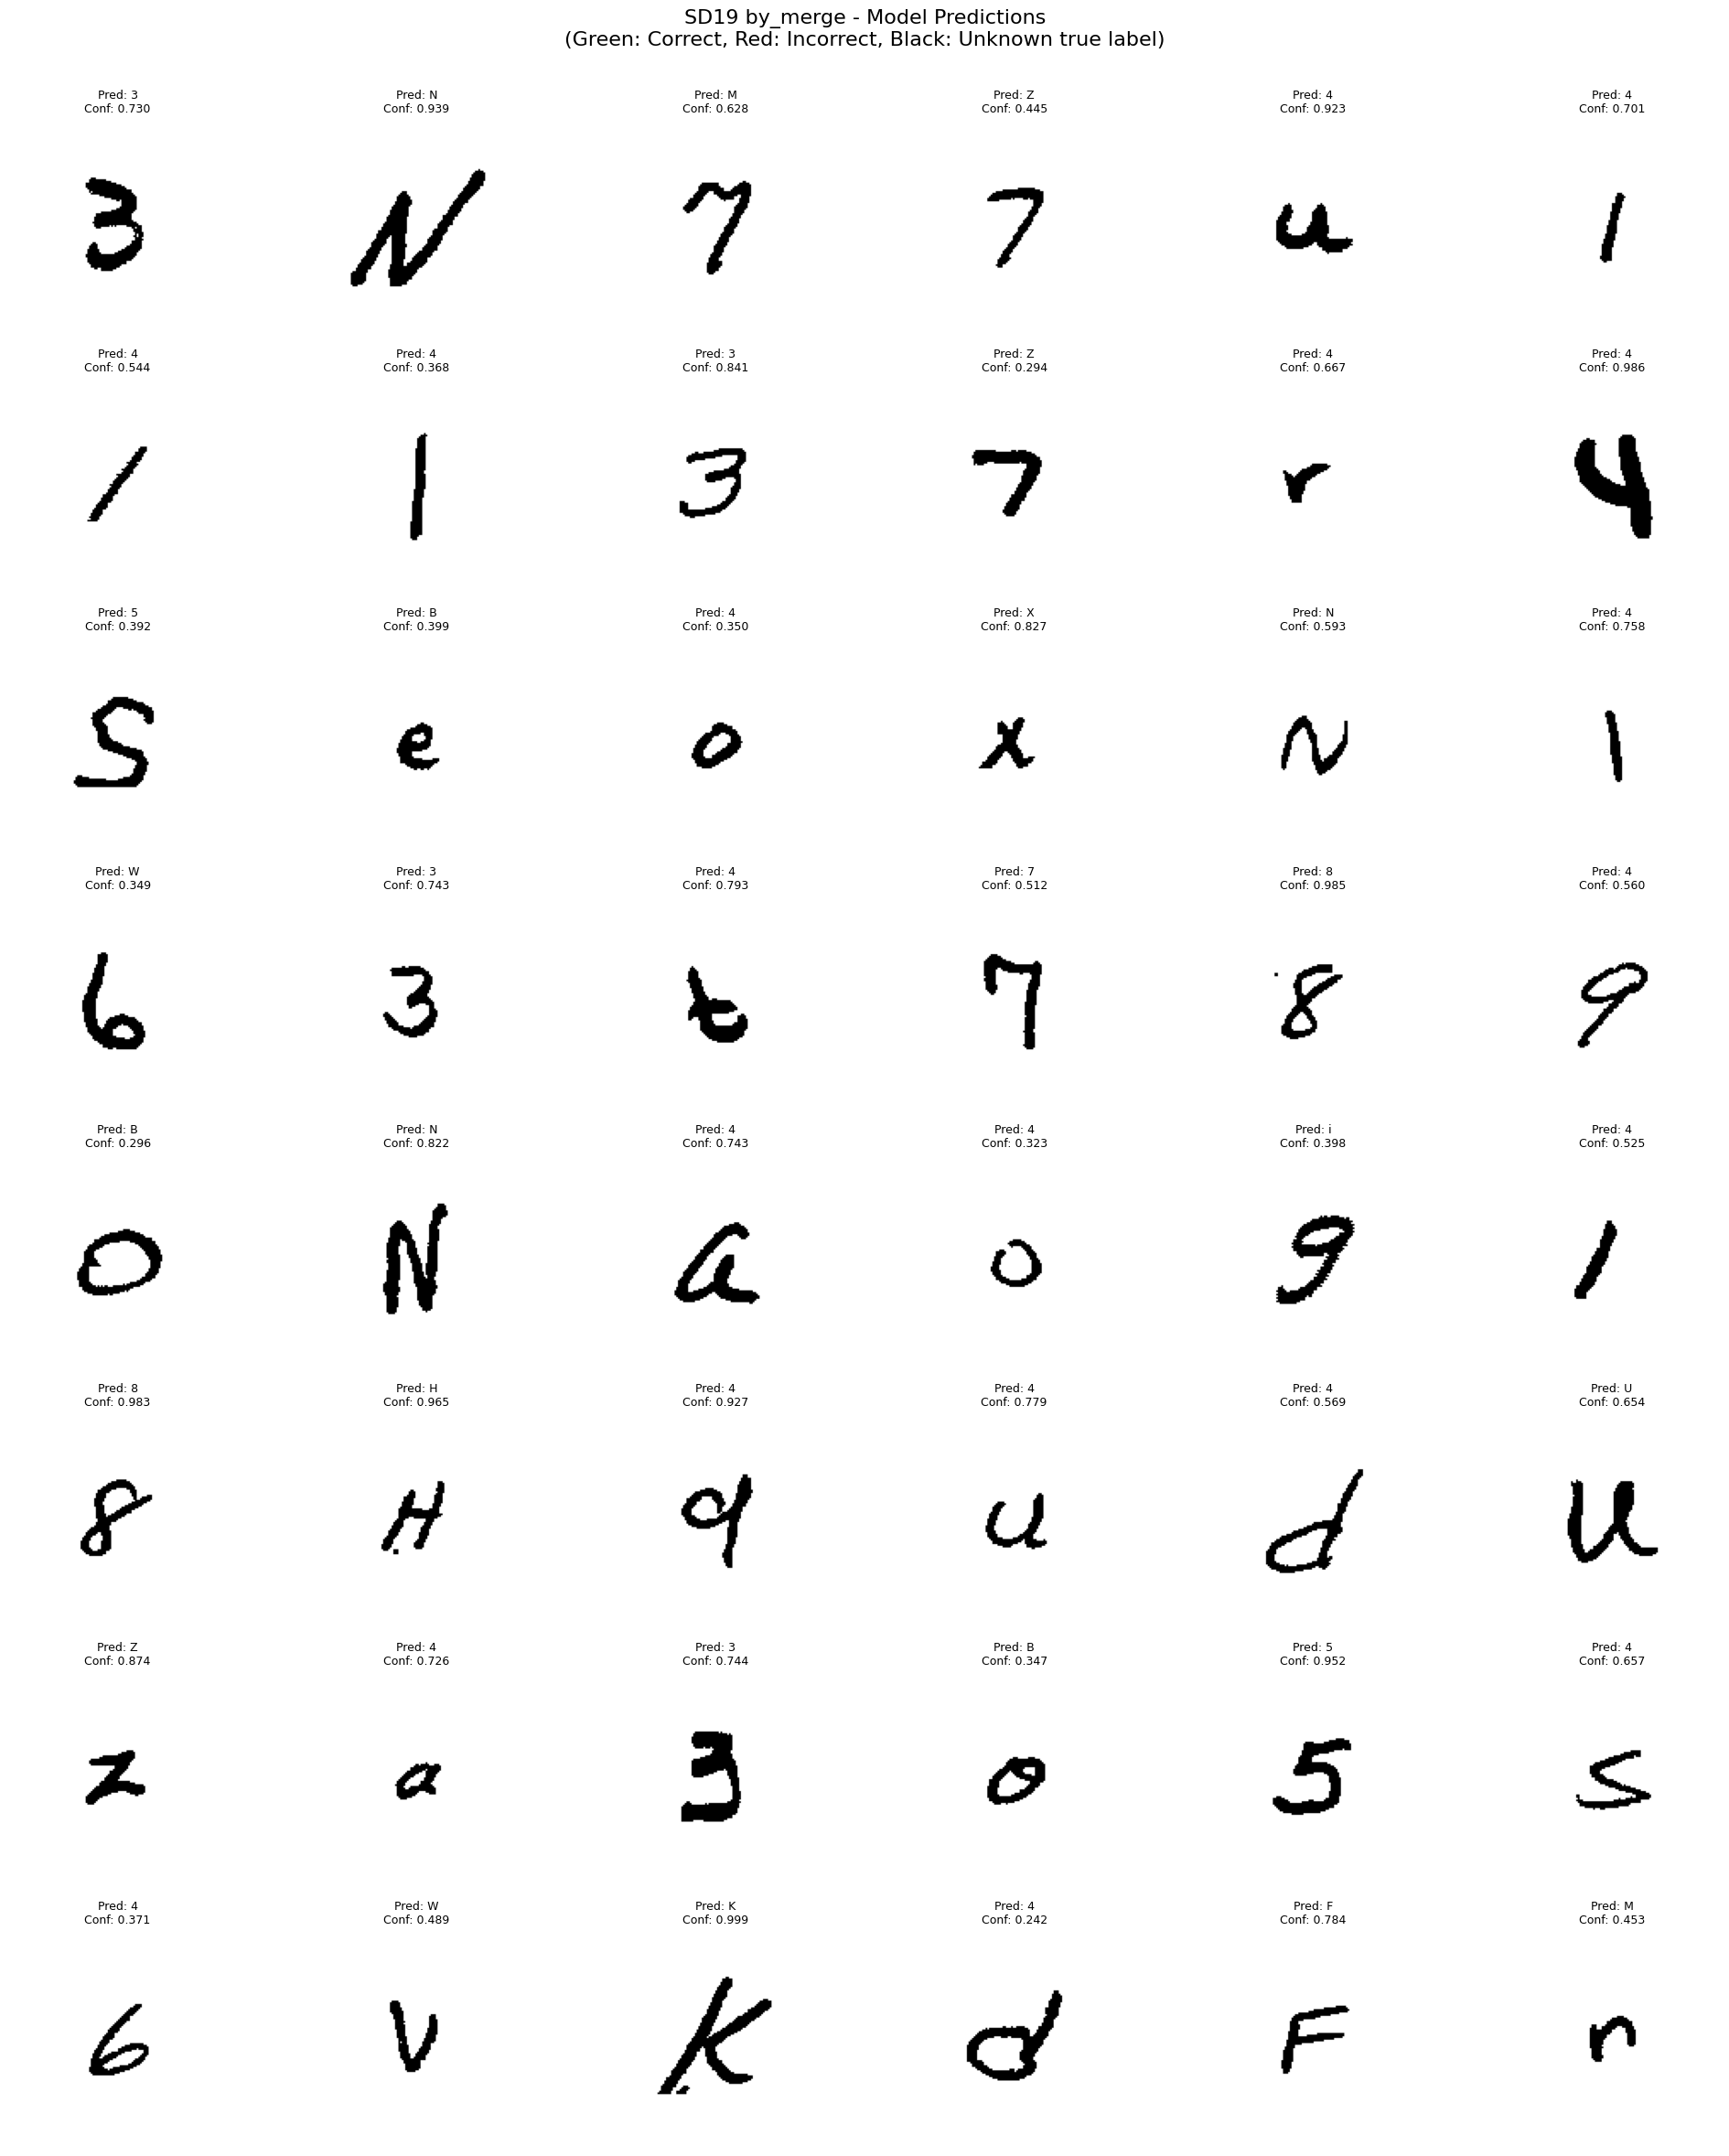

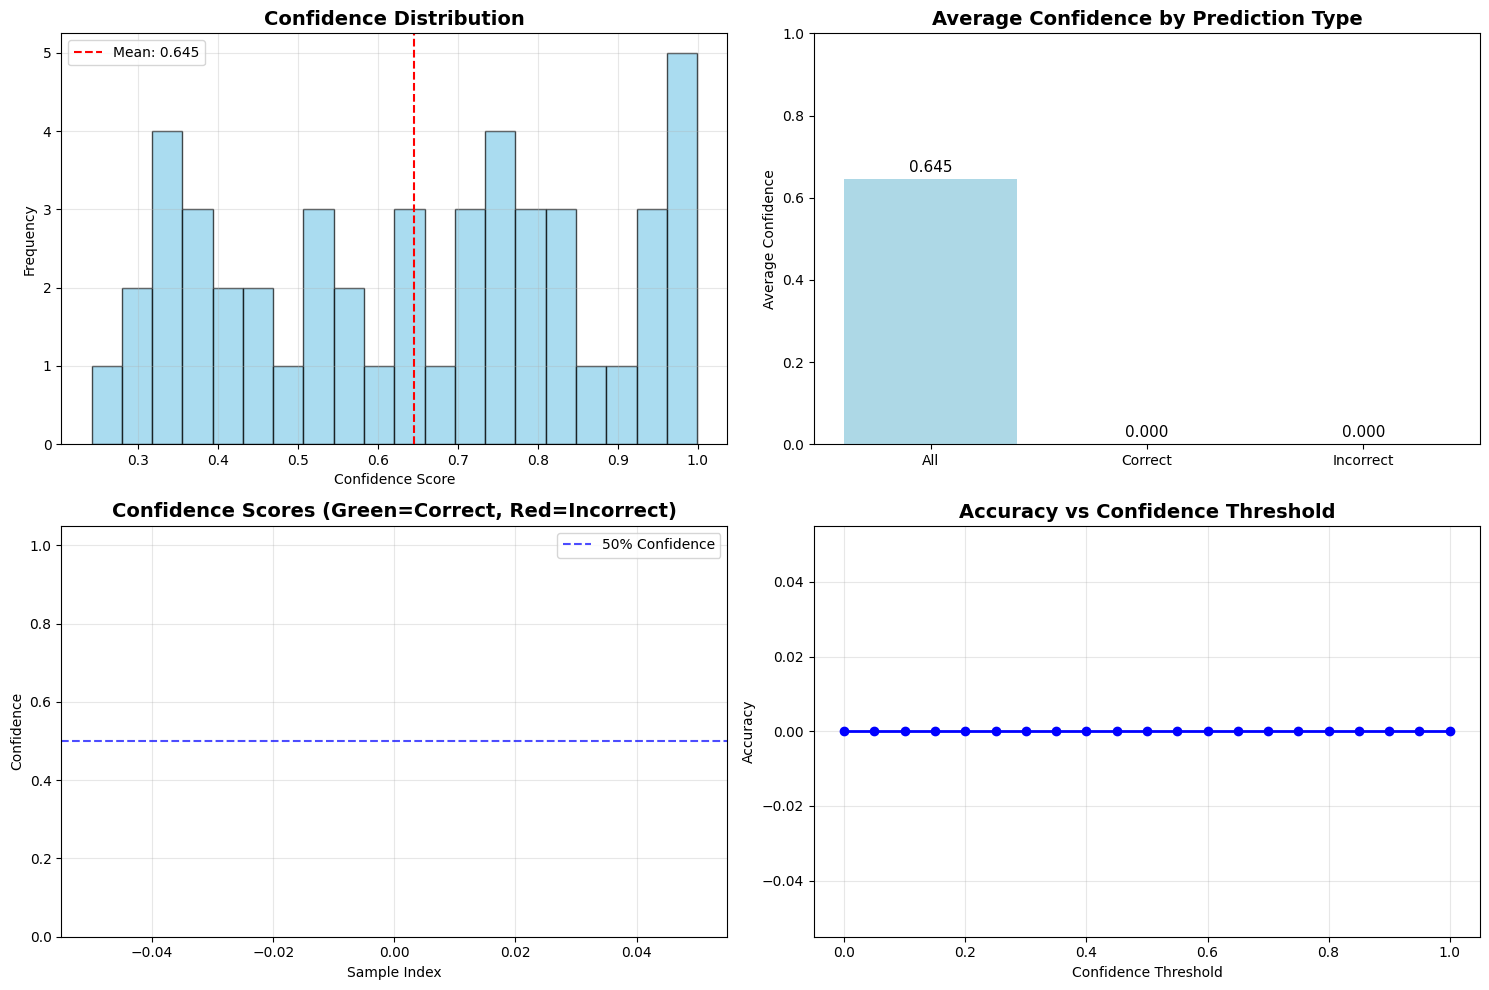


🔍 Example Predictions:
   ❓ 3 (conf: 0.730) - True: Unknown
   ❓ N (conf: 0.939) - True: Unknown
   ❓ M (conf: 0.628) - True: Unknown
   ❓ Z (conf: 0.445) - True: Unknown
   ❓ 4 (conf: 0.923) - True: Unknown
   ❓ 4 (conf: 0.701) - True: Unknown
   ❓ 4 (conf: 0.544) - True: Unknown
   ❓ 4 (conf: 0.368) - True: Unknown
   ❓ 3 (conf: 0.841) - True: Unknown
   ❓ Z (conf: 0.294) - True: Unknown


In [19]:
# sd19_bymerge_testing_analysis.py
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tqdm import tqdm
import random

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# SD19 by_merge class mapping (47 classes)
SD19_CLASS_NAMES = [
    # Digits 0-9 (10 classes)
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',

    # Uppercase A-Z (26 classes) - classes 10-35
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z',

    # Lowercase a-k (11 classes) - classes 36-46
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k'
]

def load_model(model_path):
    """Load the trained model with error handling"""
    try:
        model = keras.models.load_model(model_path)
        print(f"✅ Model loaded successfully from {model_path}")
        print(f"📊 Model input shape: {model.input_shape}")
        print(f"📊 Model output shape: {model.output_shape}")
        return model
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

def load_and_preprocess_image(image_path, img_size=(128, 128), invert=True):
    """Load and preprocess a single image for SD19 dataset"""
    try:
        # Load image in grayscale
        img = Image.open(image_path).convert('L')

        # Resize to match model's expected input
        img = img.resize(img_size)

        # Convert to numpy array
        img_array = np.array(img, dtype=np.float32)

        # Normalize pixel values to [0, 1]
        img_array = img_array / 255.0

        # Invert if needed (SD19 images are often white on black)
        if invert:
            img_array = 1.0 - img_array

        # Add batch and channel dimensions
        img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
        img_array = np.expand_dims(img_array, axis=0)   # Add batch dimension

        return img_array
    except Exception as e:
        print(f"❌ Error loading image {image_path}: {e}")
        return None

def predict_on_image(model, image_path, class_names):
    """Make prediction on a single image"""
    processed_image = load_and_preprocess_image(image_path)
    if processed_image is None:
        return None, None, None

    # Make prediction
    predictions = model.predict(processed_image, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    all_probs = predictions[0]

    return predicted_class, confidence, all_probs

def get_actual_class_from_path(image_path, class_names):
    """Extract actual class from image path for SD19 dataset"""
    try:
        # Get folder name (which should be the class label)
        folder_name = os.path.basename(os.path.dirname(image_path))

        # Check if folder name is a direct match
        if folder_name in class_names:
            return class_names.index(folder_name), folder_name

        # Check if folder name is a number that corresponds to class index
        if folder_name.isdigit():
            class_idx = int(folder_name)
            if 0 <= class_idx < len(class_names):
                return class_idx, class_names[class_idx]

        return None, "Unknown"
    except:
        return None, "Unknown"

def analyze_sd19_dataset(model, test_dir, class_names, num_samples=50):
    """Comprehensive analysis of SD19 by_merge dataset"""
    print(f"🔍 Analyzing SD19 by_merge dataset in: {test_dir}")

    # Get all image paths
    image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif']
    image_paths = []

    for root, _, files in os.walk(test_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_paths.append(os.path.join(root, file))

    if not image_paths:
        print("❌ No images found in the directory")
        return

    print(f"📁 Found {len(image_paths)} images")

    # Select samples for analysis
    if len(image_paths) > num_samples:
        selected_paths = random.sample(image_paths, num_samples)
    else:
        selected_paths = image_paths

    # Collect predictions
    results = []
    for image_path in tqdm(selected_paths, desc="Processing images"):
        actual_idx, actual_label = get_actual_class_from_path(image_path, class_names)
        pred_class, confidence, all_probs = predict_on_image(model, image_path, class_names)

        if pred_class is not None:
            pred_label = class_names[pred_class] if pred_class < len(class_names) else f"Unknown({pred_class})"
            results.append({
                'image_path': image_path,
                'actual_idx': actual_idx,
                'actual_label': actual_label,
                'predicted_idx': pred_class,
                'predicted_label': pred_label,
                'confidence': confidence,
                'correct': actual_idx == pred_class if actual_idx is not None else None
            })

    return results, selected_paths

def plot_predictions_grid(results, class_names, num_cols=6):
    """Plot grid of predictions with actual vs predicted labels"""
    num_images = len(results)
    num_rows = (num_images + num_cols - 1) // num_cols

    plt.figure(figsize=(20, 3 * num_rows))
    plt.suptitle('SD19 by_merge - Model Predictions\n(Green: Correct, Red: Incorrect, Black: Unknown true label)',
                 fontsize=16, y=0.98)

    for i, result in enumerate(results):
        plt.subplot(num_rows, num_cols, i + 1)

        # Load and display image
        try:
            img = Image.open(result['image_path']).convert('L')
            img = img.resize((128, 128))
            plt.imshow(img, cmap='gray')
        except:
            plt.text(0.5, 0.5, 'Image load error', ha='center', va='center')

        # Determine title color
        if result['actual_label'] == "Unknown":
            title_color = 'black'
            title_text = f'Pred: {result["predicted_label"]}\nConf: {result["confidence"]:.3f}'
        else:
            title_color = 'green' if result['correct'] else 'red'
            title_text = f'True: {result["actual_label"]}\nPred: {result["predicted_label"]}\nConf: {result["confidence"]:.3f}'

        plt.title(title_text, color=title_color, fontsize=9, pad=5)
        plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

def plot_confusion_matrix(results, class_names):
    """Plot confusion matrix for known labels"""
    # Filter results with known actual labels
    known_results = [r for r in results if r['actual_idx'] is not None and r['predicted_idx'] is not None]

    if not known_results:
        print("❌ No known labels for confusion matrix")
        return

    actuals = [r['actual_idx'] for r in known_results]
    predictions = [r['predicted_idx'] for r in known_results]

    # Create confusion matrix
    cm = confusion_matrix(actuals, predictions, labels=range(len(class_names)))

    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - SD19 by_merge Dataset', fontsize=16, pad=20)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('Actual Labels', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\n📊 Classification Report:")
    print(classification_report(actuals, predictions,
                               target_names=class_names, zero_division=0))

def plot_confidence_analysis(results):
    """Plot confidence analysis"""
    confidences = [r['confidence'] for r in results if r['confidence'] is not None]
    correct_confidences = [r['confidence'] for r in results if r.get('correct')]
    incorrect_confidences = [r['confidence'] for r in results if r.get('correct') == False]

    plt.figure(figsize=(15, 10))

    # 1. Confidence distribution
    plt.subplot(2, 2, 1)
    plt.hist(confidences, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(confidences), color='red', linestyle='--',
                label=f'Mean: {np.mean(confidences):.3f}')
    plt.title('Confidence Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)

    # 2. Confidence by correctness
    plt.subplot(2, 2, 2)
    categories = ['All', 'Correct', 'Incorrect']
    means = [
        np.mean(confidences) if confidences else 0,
        np.mean(correct_confidences) if correct_confidences else 0,
        np.mean(incorrect_confidences) if incorrect_confidences else 0
    ]

    bars = plt.bar(categories, means, color=['lightblue', 'lightgreen', 'lightcoral'])
    plt.title('Average Confidence by Prediction Type', fontsize=14, fontweight='bold')
    plt.ylabel('Average Confidence')
    plt.ylim(0, 1)

    for bar, value in zip(bars, means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=11)

    # 3. Confidence scatter plot
    plt.subplot(2, 2, 3)
    colors = ['green' if r.get('correct') else 'red' for r in results if r.get('correct') is not None]
    valid_results = [r for r in results if r.get('correct') is not None]
    plt.scatter(range(len(valid_results)), [r['confidence'] for r in valid_results],
                c=colors, alpha=0.6, s=50)
    plt.axhline(y=0.5, color='blue', linestyle='--', alpha=0.7, label='50% Confidence')
    plt.title('Confidence Scores (Green=Correct, Red=Incorrect)', fontsize=14, fontweight='bold')
    plt.xlabel('Sample Index')
    plt.ylabel('Confidence')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(alpha=0.3)

    # 4. Accuracy vs Confidence threshold
    plt.subplot(2, 2, 4)
    thresholds = np.linspace(0, 1, 21)
    accuracies = []
    for threshold in thresholds:
        high_conf_results = [r for r in results if r['confidence'] >= threshold and r.get('correct') is not None]
        if high_conf_results:
            accuracy = sum(1 for r in high_conf_results if r['correct']) / len(high_conf_results)
            accuracies.append(accuracy)
        else:
            accuracies.append(0)

    plt.plot(thresholds, accuracies, 'b-', marker='o', linewidth=2)
    plt.title('Accuracy vs Confidence Threshold', fontsize=14, fontweight='bold')
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Accuracy')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_class_performance(results, class_names):
    """Plot performance by class"""
    known_results = [r for r in results if r['actual_idx'] is not None and r.get('correct') is not None]

    if not known_results:
        return

    # Calculate accuracy per class
    class_stats = {}
    for class_idx in range(len(class_names)):
        class_results = [r for r in known_results if r['actual_idx'] == class_idx]
        if class_results:
            accuracy = sum(1 for r in class_results if r['correct']) / len(class_results)
            class_stats[class_idx] = {
                'accuracy': accuracy,
                'count': len(class_results),
                'class_name': class_names[class_idx]
            }

    # Sort by accuracy
    sorted_stats = sorted(class_stats.items(), key=lambda x: x[1]['accuracy'])

    plt.figure(figsize=(15, 8))
    classes = [f"{stats['class_name']}\n(n={stats['count']})" for _, stats in sorted_stats]
    accuracies = [stats['accuracy'] for _, stats in sorted_stats]

    colors = ['green' if acc >= 0.7 else 'orange' if acc >= 0.4 else 'red' for acc in accuracies]

    bars = plt.barh(range(len(classes)), accuracies, color=colors)
    plt.yticks(range(len(classes)), classes)
    plt.title('Accuracy by Class', fontsize=16, fontweight='bold')
    plt.xlabel('Accuracy')
    plt.xlim(0, 1)

    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{acc:.3f}', ha='left', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

def main():
    # Configuration
    MODEL_PATH = "/content/best_model_optimized_2.keras"  # Update this path
    TEST_DIR = "/content/by_merge"  # Update this path

    print("🎯 SD19 by_merge Dataset Testing Analysis")
    print("=" * 50)
    print(f"📋 Classes: {len(SD19_CLASS_NAMES)}")
    print(f"   0-9: Digits")
    print(f"   10-35: Uppercase A-Z")
    print(f"   36-46: Lowercase a-k")
    print("=" * 50)

    # Load model
    model = load_model(MODEL_PATH)
    if model is None:
        return

    # Analyze dataset
    results, image_paths = analyze_sd19_dataset(model, TEST_DIR, SD19_CLASS_NAMES, num_samples=48)

    if not results:
        print("❌ No results to analyze")
        return

    # Calculate overall statistics
    known_results = [r for r in results if r.get('correct') is not None]
    if known_results:
        accuracy = sum(1 for r in known_results if r['correct']) / len(known_results)
        avg_confidence = np.mean([r['confidence'] for r in results])

        print(f"\n📊 Overall Statistics:")
        print(f"   ✅ Accuracy: {accuracy:.3f} ({sum(1 for r in known_results if r['correct'])}/{len(known_results)} correct)")
        print(f"   🎯 Average Confidence: {avg_confidence:.3f}")
        print(f"   📈 Correct predictions confidence: {np.mean([r['confidence'] for r in known_results if r['correct']]):.3f}")
        print(f"   📉 Incorrect predictions confidence: {np.mean([r['confidence'] for r in known_results if not r['correct']]):.3f}")

    # Plot results
    print("\n📈 Generating visualizations...")

    # 1. Prediction grid
    plot_predictions_grid(results, SD19_CLASS_NAMES)

    # 2. Confusion matrix (if we have known labels)
    if any(r['actual_idx'] is not None for r in results):
        plot_confusion_matrix(results, SD19_CLASS_NAMES)

    # 3. Confidence analysis
    plot_confidence_analysis(results)

    # 4. Class performance
    plot_class_performance(results, SD19_CLASS_NAMES)

    # Show some example predictions
    print("\n🔍 Example Predictions:")
    for i, result in enumerate(results[:10]):
        status = "✅" if result.get('correct') else "❌" if result.get('correct') == False else "❓"
        print(f"   {status} {result['predicted_label']} (conf: {result['confidence']:.3f}) - True: {result['actual_label']}")

if __name__ == "__main__":
    main()